# Notes
This notebook is completely runnable, however, it will take quiet some time (maybe >1hour), as it will caculate the sentiment of every tweet and every tweet description.
However, you can avoid that, by downloading the according data <a href = "https://github.com/carlomarxdk/twitter/tree/master/ipynb/tweet_sentiments.npy">here</a>, and skipping this [section](#skip), and instead going directly to [this one](#Loading-Dataset-here).

# Loading Packages

In [82]:
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as md

from itertools import count
from collections import Counter
import matplotlib

from nltk.tokenize import RegexpTokenizer


from time import mktime
from datetime import datetime
from datetime import timedelta

from scipy import stats
import scipy
#scipy.ndimage.filters.gaussian_filter¶
from scipy import ndimage
from matplotlib.pyplot import cm

import networkx as nx

from sklearn.metrics import confusion_matrix

# Defining parsing function

In [2]:
import sys

def parse(f,chunksize = 100000, cols = None, test_bool = False, dtype = None):
    lines = 9041*1000
    for i,gm_chunk in enumerate(pd.read_csv("../ira_tweets_csv_hashed.csv",chunksize = chunksize, usecols = cols, dtype = dtype, low_memory = False)):
        f(gm_chunk)
        if test_bool:
            print('Done')
            break
        j = i*chunksize/lines
        sys.stdout.write('\r')
        # the exact output you're looking for:
        bar_int = int(j*20+1)
        sys.stdout.write("[%-20s] %d%%" % ('='*bar_int, int(j*100+1)))
        sys.stdout.flush()

# Creating large array used for analyzing

## Loading sentiment dataset

In [3]:
#import the dataset
df_labmt = pd.read_csv("Data_Set_S1.txt", delimiter = '\t', header = 2)

In [4]:
#create a dictionary with the words as keys
#and their happiness_average as values
havg_w = {w:v for w,v in zip(df_labmt['word'], df_labmt['happiness_average'])}

In [5]:
#function that returns the sentiment of a wordlist
#if the wordlist is empty, than it will return
#the type np.nan, which than wont be incorporated for calculating the mean

#SENTIMENTS
def h_avg(wordlist):
    if len(wordlist) == 0:
        return np.nan
    else:
      #np.nanmean calculates the mean without incorporating np.nan
        return np.nanmean([havg_w.get(w, np.nan) for w in wordlist])

#### Calculating number of lines and create langs set

In [6]:
cols = ['tweet_language', 'account_language']


num_lines = 0
langs = set()


def f(chunk):
    global langs
    global num_lines
    for t,a in zip(chunk['tweet_language'], chunk['account_language']):
        num_lines = num_lines + 1
        langs.add(t)
        langs.add(a)
    
parse(f, 100000, test_bool = False)

[====================] 100%

In [7]:
num_lines

9041308

Skip this section to save time and download the data <a href = " ">here.</a>

# creating large array 'sents' with all important data for sentiment analysis
<a id='skip'></a>

(including sentiments of tweets and profile desciption)

In [8]:
langs_dict = {l:i for i,l in enumerate(list(langs))}

In [9]:
min_times = datetime(2009, 5, 9, 15, 59)

In [10]:
to_date_time = lambda t: datetime.strptime(t, '%Y-%m-%d %H:%M')

In [11]:
tokenizer = RegexpTokenizer(r'\w+')

cols = ['tweet_text', 'tweet_language', 'like_count', 'retweet_count', 'quote_count', 'reply_count', 'account_language', 'user_profile_description', 'tweet_time', 'follower_count', 'userid']

k = 0

sents = np.zeros((num_lines + 1, 13))
#tweets = []


def f(chunk):
    global k
    global sents
    
    for uid,t,lang,content,likes,retw,quotes,replys,ac_lang,desc, fol_count in zip(chunk['userid'],chunk['tweet_time'],chunk['tweet_language'], chunk['tweet_text'], chunk['like_count'], chunk['retweet_count'], chunk['quote_count'], chunk['reply_count'], chunk['account_language'], chunk['user_profile_description'], chunk['follower_count']):
        k = k + 1
        sents[k,0] = (to_date_time(t) - min_times).days
        sents[k,1] = langs_dict[lang]
        if type(content) != float and len(content) > 0:
            words = [w.lower() for w in tokenizer.tokenize(content)]
            sents[k,2] = len(words)
            sents[k,3] = h_avg(words)
            
        sents[k,4] = likes
        sents[k,5] = retw
        sents[k,6] = quotes
        sents[k,7] = replys
            
        sents[k,8] = langs_dict[ac_lang]
        if type(desc) != float and len(desc) > 0:
            words = [w.lower() for w in tokenizer.tokenize(desc)]
            sents[k,9] = h_avg(words)
            sents[k,10] = len(words)
        
        sents[k,11] = fol_count
        sents[k,12] = sum(bytearray(str(uid), encoding = 'utf8'))
            
        

        
        #tweets.extend([content])

parse(f, 10000, cols = cols, test_bool = False)

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


[====================] 100%

In [12]:
np.save("tweet_sentiments", sents)

# Loading Dataset here
<a id='loading'></a>

In [13]:
sents = np.load('tweet_sentiments.npy')

In [14]:
def clean_nan_zeros(raw):
    clean = raw[~np.isnan(raw)]
    clean = clean[clean != 0]
    return clean

# Basic stats like/retweet/follow-distribution

This is intended to visualize the basic like/reetweets/follower distribution of the tweets/accounts in the dataset.

Therefor, a log-log plot of thes distribtions was created:

### #Tweets(#Likes)

In [15]:
like_val, like_bins = np.histogram(clean_nan_zeros(sents[:,4]), bins = 200)

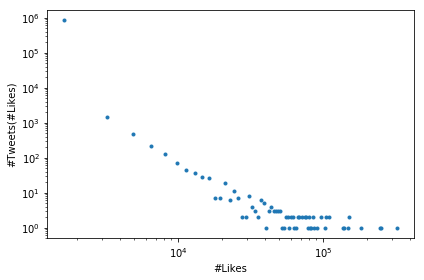

In [16]:
plt.loglog(like_bins[1:], like_val, '.')

plt.xlabel("#Likes")
plt.ylabel("#Tweets(#Likes)")

plt.tight_layout()

plt.savefig("loglog-like-dist.png", dpi = 400)

### #tweets(#retweets)

In [17]:
retw_val, retw_bins = np.histogram(clean_nan_zeros(sents[:,5]), bins = 100)

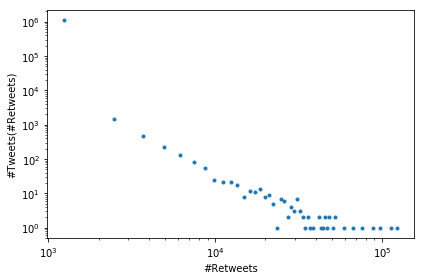

In [18]:
plt.loglog(retw_bins[1:], retw_val, '.')

plt.xlabel("#Retweets")
plt.ylabel("#Tweets(#Retweets)")

plt.tight_layout()

plt.savefig("loglog-retw-dist.png", dpi = 400)

### #Accounts(#Followers)

In [19]:
foll_val, foll_bins = np.histogram(clean_nan_zeros(sents[:,11]), bins = 100)

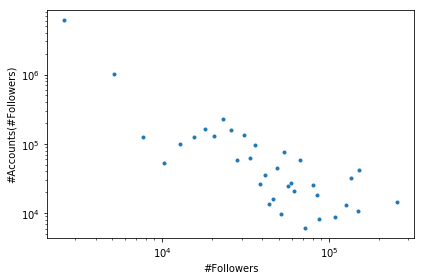

In [20]:
plt.loglog(foll_bins[1:], foll_val, '.')

plt.xlabel("#Followers")
plt.ylabel("#Accounts(#Followers)")

plt.tight_layout()

plt.savefig("loglog-follow-dist.png", dpi = 400)

In [21]:
stats.linregress(np.log(like_bins[1:]), np.log(1+like_val))

LinregressResult(slope=-1.2844971996140933, intercept=15.642609365065711, rvalue=-0.8473726347973733, pvalue=2.469678913958819e-56, stderr=0.05720310308825702)

In [22]:
stats.linregress(np.log(retw_bins[1:]), np.log(1+retw_val))

LinregressResult(slope=-1.9026854471431087, intercept=21.50082973545731, rvalue=-0.9031979099612614, pvalue=8.943888752514483e-38, stderr=0.09133881603013037)

In [23]:
stats.linregress(np.log(foll_bins[1:]), np.log(1+foll_val))

LinregressResult(slope=-4.396851235574422, intercept=54.297791908227225, rvalue=-0.7800871730208131, pvalue=1.1277805973850757e-21, stderr=0.3562308385627087)

All 3 of these distribtuions seem to have the the form of a power law, which was expected.

This was verfied doing a linear regression on this plots.

The Retweets most seem to resemble a power law most closely, however, since this is not a maximum likelihood fit, this numbers should not be taken too seriously.

# Analyzing Tweet/Description sentiments

Here i am creating a histogram of the number of tweets with a specific sentiment, with the intension to explore whether there is a difference between them.
i.e.: are there more tweets with a lower sentiment, than profile descriptions? etc.

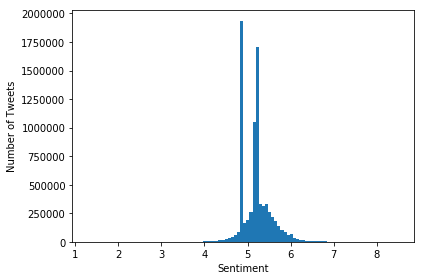

In [24]:
_ = plt.hist(clean_nan_zeros(sents[:,3]), bins = 100)
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.savefig("tw_sentiment.png", dpi = 400)

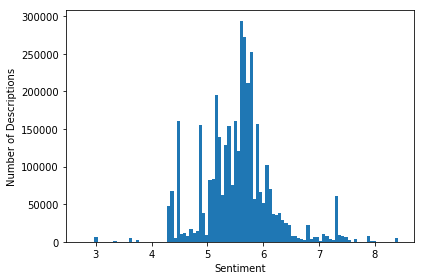

In [25]:
_ = plt.hist(clean_nan_zeros(sents[:,9]), bins = 100)
plt.xlabel('Sentiment')
plt.ylabel('Number of Descriptions')
plt.tight_layout()
plt.savefig("desc_sentiment.png", dpi = 400)

In [26]:
def clean_sents(raw_sents):
    cleaned_sents = clean_nan_zeros(raw_sents)
    cleaned_sents = cleaned_sents[cleaned_sents < 10]
    return cleaned_sents

In [27]:
tw_sents = clean_sents(sents[:,3])
desc_sents = clean_sents(sents[:,9])

In [28]:
np.average(tw_sents), np.std(tw_sents)

(5.196943870758352, 0.33854862686533915)

In [29]:
np.average(desc_sents), np.std(desc_sents)

(5.544027008321617, 0.6291511879991792)

As can be seen, the difference is vanishable. i.e.: There is no significant difference between the 2 distribtions. (neither in form or mean/standard deviation)

In the next cells i will clean the distribtions even further and normalize them (set the maximum to 1) to make the distribtuions directly compareable

In [30]:
tw_hist, tw_bins = np.histogram(tw_sents, bins = np.linspace(0.01,10, 1000))
desc_hist, desc_bins = np.histogram(desc_sents, bins = np.linspace(0.01,10,100))
tw_hist_cleaned = np.array([sent if sent < 50000 else np.nan for sent in tw_hist])

In [31]:
A = tw_hist_cleaned
ok = ~np.isnan(A)
xp = ok.ravel().nonzero()[0]
fp = A[~np.isnan(A)]
x  = np.isnan(A).ravel().nonzero()[0]

A[np.isnan(A)] = np.interp(x, xp, fp)

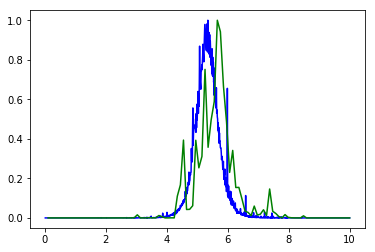

In [32]:
plt.plot(tw_bins[1:], A/max(A), color = 'blue')
plt.plot(desc_bins[1:], desc_hist/max(desc_hist), color = 'green' )

plotting this in plotly

In [33]:
import plotly.offline as py
import plotly.graph_objs as go

tw_sent_trace = go.Scatter(
    x = tw_bins[1:],
    y = A/max(A),
    name = "Tw"
)

desc_sent_trace = go.Scatter(
    x = desc_bins[1:],
    y = desc_hist/max(desc_hist),
    name = "Desc"
)

data = [tw_sent_trace, desc_sent_trace]

layout = dict(title = "Histogram of Sentiments of Tweets and Descriptions",
             xaxis = dict(title = "Sentiment"),
             yaxis = dict(title = "Count/Sentiment"),
             )

fig = dict(data = data, layout = layout)

py.plot(fig, filename = "hist_sentiment_tw_desc.html")

'file:///mnt/c/Users/hurt0jan/Documents/projects/twitter/hist_sentiment_tw_desc.html'

Plot can be found here: https://carlomarxdk.github.io/twitter/plots/hist_sentiment_tw_desc.html

# Relationshipt between tweet and description sentiments

Another idea/theory explored is, whether there is a relationship between the sentiment of the profile descriptions and the sentiment of the tweets of the according accounts.

To visualize this, a heatmap of the sentiment of a specific tweet, and the sentiment of the according account was created

In [34]:
raw_tw_sents = sents[:,3]
raw_desc_sents = sents[:,9]

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning:

divide by zero encountered in log



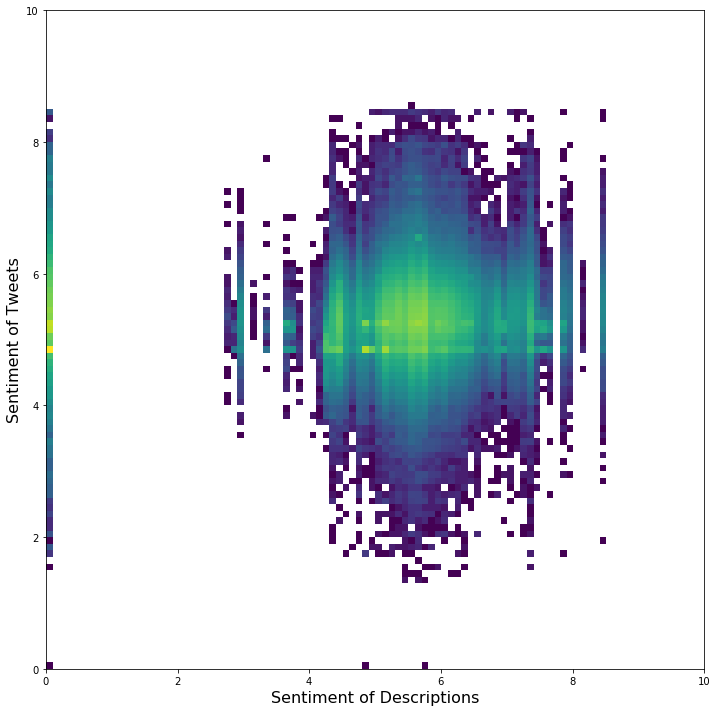

In [35]:
plt.figure(figsize=(10,10))

bins_x = np.linspace(0,10, 100)
bins_y = np.linspace(0,10,1000)

bins = np.meshgrid(bins_x, bins_y)
heatmap, xedges, yedges = np.histogram2d(raw_desc_sents, raw_tw_sents, bins=[100,100], range = [[0, 10], [0, 10]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]



plt.title("", size = 20)

plt.clf()
plt.imshow(np.log(heatmap).T, extent=extent, origin='lower')

plt.xlabel("Sentiment of Descriptions", size = 16)
plt.ylabel("Sentiment of Tweets", size = 16)

plt.tight_layout()

plt.savefig('tw_sents-desc_sents.png', dpi = 300)
plt.show()

However, as can be seen in this heatmap, there does not seem to be a clear relationship between them.
If there was a relationship between them, i expected there to be a line around the 1st median, however, there seem to be some horizontal and vertical lines, which clearly contradicts this theory. i.e.: no relationship between the tweet/description sentiment seems apparent.

# Average tweet sentiment to followers
It was also explored whether there is a relationship between the average tweet-sentiment of a specific account and its number of followers.
This was also done by creating a heatmap of the average tweets sentiment to the logarithm of the number of followers:

In [36]:
uids = set(sents[:,12])

In [37]:
avg_utw_sent = [np.nanmean(sents[sents[:,12] == i,3]) for i in uids]

In [38]:
follow_uid = [max(sents[sents[:,12] ==i,11]) for i in uids]

In [39]:
follow_uid = np.array(follow_uid)
avg_utw_sent = np.array(avg_utw_sent)

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

divide by zero encountered in log

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning:

divide by zero encountered in log

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



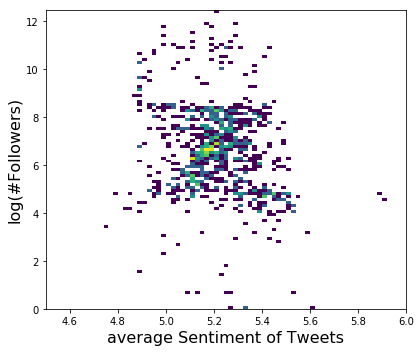

In [40]:
plt.figure(figsize=(10,5))

bins_x = np.linspace(0,10, 100)
bins_y = np.linspace(0,10,1000)

bins = np.meshgrid(bins_x, bins_y)
heatmap, xedges, yedges = np.histogram2d(avg_utw_sent, np.log(follow_uid), bins=[500,100], range = [[0, 10], [0, np.log(max(follow_uid))]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


plt.clf()
plt.imshow(np.log(heatmap).T, extent=extent, origin='lower')

plt.xlabel("average Sentiment of Tweets", size = 16)
plt.ylabel("log(#Followers)", size = 16)
plt.xlim((4.5,6))
plt.axes().set_aspect(0.1)
plt.tight_layout()

#plt.savefig('tw_sents-desc_sents.png', dpi = 300)
plt.show()

Double checking by doing a linear regression.

In [41]:
stats.linregress(avg_utw_sent, np.log(1 + follow_uid))

LinregressResult(slope=-0.27750376956454725, intercept=8.007646481659645, rvalue=-0.03406587335861972, pvalue=0.31332835559261446, stderr=0.2750712265916034)

However, as can be seen in the heatmap, and the verification through the linear regression, there also seems to be no relationshib between those.
i.e.: Accounts with a higher/lower average sentiment are not expected to have more followers.

# #Retweets/#Likes depending on sentiment
It was also explored whether there is a relationship between the number of likes/retweets and the sentiment of a specific tweet.
This was also done by using heatmaps

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

divide by zero encountered in log

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

divide by zero encountered in log



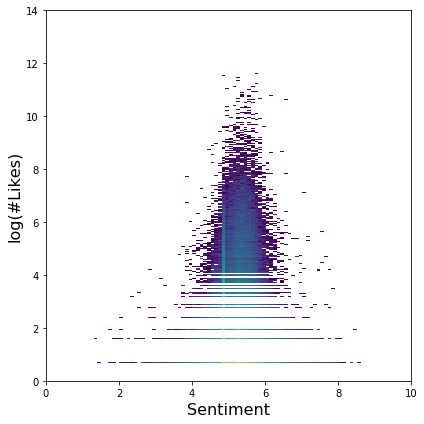

In [42]:
plt.figure(figsize=(6,6))

bins_x = np.linspace(0,10, 100)
bins_y = np.linspace(0,10,1000)

heatmap, xedges, yedges = np.histogram2d(raw_tw_sents, np.log(sents[:,4]), bins=[100,1000], range = [[0, 10], [0, 14]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(np.log(heatmap).T, extent=extent, origin='lower')
plt.axis('auto')

plt.xlabel("Sentiment", size = 16)
plt.ylabel("log(#Likes)", size = 16)

plt.tight_layout()

plt.savefig('sent-like-dist.png', dpi = 400)
plt.show()

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

divide by zero encountered in log

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

divide by zero encountered in log



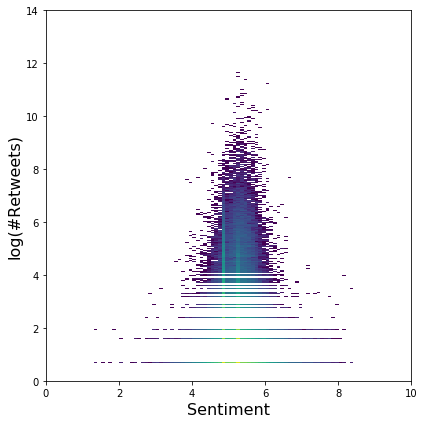

In [43]:
plt.figure(figsize=(6,6))

bins_x = np.linspace(0,10, 100)
bins_y = np.linspace(0,10,1000)

heatmap, xedges, yedges = np.histogram2d(raw_tw_sents, np.log(sents[:,5]), bins=[100,1000], range = [[0, 10], [0, 14]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(np.log(heatmap).T, extent=extent, origin='lower')
plt.axis('auto')

plt.xlabel("Sentiment", size = 16)
plt.ylabel("log(#Retweets)", size = 16)

plt.tight_layout()

plt.savefig('sent-retw-dist.png', dpi = 400)
plt.show()

Both distribtuions seem remarkabely similar, however there is nothing especially striking.
The only thing which is kind of interesting is, that tweets that seem to be more popular are more likely to have a sentiment around $5.5$.

# Sentiment Analysis according to Days

It was also explored, whether there is *anything* interesting about the average sentiment of each day. i.e.: are there specific drop offs in time, when the sentiment of the tweets is especially low/high? can those be related to specific events in real life?

For this an interactive plotly-plot was created.
Since the average sentiment/day of the troll network alone would not be very helpful, as a comparison baseline, the average sentiment of whole twitter (data retrieved from here https://hedonometer.org/about.html) was also plotted.

In [44]:
tw_days = sents[:,0]

In [45]:
sents_by_day = []
for d in range(int(np.max(tw_days))):
    sents_by_day.append([raw_tw_sents[tw_days == d]])

In [46]:
avg_sents_by_day = [np.nanmean(s) for s in sents_by_day]

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

Mean of empty slice



In [47]:
st_sents_by_day = [np.nanstd(s) for s in sents_by_day]

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning:

Degrees of freedom <= 0 for slice.



In [48]:
df_sents = pd.read_csv('sumhapps.csv')
to_date_time2 = lambda t: datetime.strptime(t, '%Y-%m-%d')

In [49]:
troll_dates = [min_times + timedelta(days = i) for i in range(len(avg_sents_by_day))]

In [50]:
total_tw_sents = [v for v in df_sents['value']]
total_dates = [to_date_time2(date) for date in df_sents['date']]

In [51]:
#import plotly.plotly as py
#import plotly.graph_objs as go

import plotly.offline as py
import plotly.graph_objs as go

troll_trace = go.Scatter(
    y =  avg_sents_by_day,
    x = troll_dates,
    name = 'troll',
    line = dict(
        width = 1
        )
    )

twitter_trace = go.Scatter(
    y = total_tw_sents,
    x = total_dates, 
    name = 'whole',
    line = dict(
        width = 1
        )
    )



data = [troll_trace, twitter_trace]

layout = dict(title = "Average Sentiment of Tweets by Days",
             yaxis = dict(title = "Average Sentiment"),
             )

fig = go.Figure(data = data, layout = layout)

py.plot(fig, filename = "average_sentiment_per_day.html")

'file:///mnt/c/Users/hurt0jan/Documents/projects/twitter/average_sentiment_per_day.html'

Plot can be found here: https://carlomarxdk.github.io/twitter/plots/average_sentiment_per_day.html

### Make it easier to compare both time series

In [52]:
norm_total_tw_sents = (np.array(total_tw_sents)-np.nanmean(total_tw_sents))/np.nanstd(total_tw_sents)
norm_troll_sents = (np.array(avg_sents_by_day)-np.nanmean(avg_sents_by_day))/np.nanstd(avg_sents_by_day)

In [53]:
troll_trace = go.Scatter(
    y = norm_troll_sents,
    x = troll_dates,
    name = 'troll',
    line = dict(
        width = 1
        )
    )

twitter_trace = go.Scatter(
    y = norm_total_tw_sents,
    x = total_dates, 
    name = 'whole',
    line = dict(
        width = 1
        )
    )



data = [troll_trace, twitter_trace]

layout = dict(title = "Average Sentiment of Tweets by Days",
             yaxis = dict(title = "Average Sentiment"),
             )

fig = go.Figure(data = data, layout = layout)

py.plot(fig, filename = "norm_sentiment_per_day.html")

'file:///mnt/c/Users/hurt0jan/Documents/projects/twitter/norm_sentiment_per_day-filtered.html'

Plot can be found here: https://carlomarxdk.github.io/twitter/plots/norm_sentiment_per_day.html

In [54]:
np.nanstd(total_tw_sents), np.nanstd(avg_sents_by_day)

(0.045493405571311055, 0.1910462648291717)

In [55]:
np.nanmean(total_tw_sents), np.nanmean(avg_sents_by_day)

(6.024227675752179, 5.244332957851656)

In the beginning the sentiment of the troll network *'jumps around'* a  lot. 
This is due to the low number of tweets in this period.
After that, the sentiment of the troll network is fairly well behaved, however, there still some significant differences to the average sentiment of whole twitter that stand out:

In general, the sentiment of the network seems to be smaller, i.e. the tweets are more 'negative'.
The sentiment for whole twitter seemt to change very slowly, and there are only very specific spikes, that mostly correspond either with holidays (thanksgiving, christmas) for *positive* spikes, or terror attacks for *negative* spikes.

In comparison, in the sentiment time series of the troll network, there seem to be clear periods of lower sentiment (e.g.:10.May 2013 to 31.Jan 2014, or 19.Oct 2015 to the 27.Dec 2015). This may correspond to specific operations of the IRA, however it was not further investigated, so we were not able to definately verify that theory.

# Activity per day

Another way, to detect certain influence operations of the troll network explored, was plotting the daily activity of the network.
i.e.: The number of tweets per day of the whole network.
This was also done by creating a plotly-plot.

In [56]:
activity = go.Scatter(
    y = np.array([len(s[0]) for s in sents_by_day], dtype = 'float'),
    x = troll_dates,
    name = 'troll',
    line = dict(
        width = 1
        )
    )

data = [activity]

layout = dict(title = "Daily activity of the troll accounts",
              yaxis = dict(title = "Number of Tweets/Day"),
              xaxis = dict(title = "Date")
             )

fig = go.Figure(data = data, layout = layout)

py.plot(fig, filename = "daily_activity.html")

'file:///mnt/c/Users/hurt0jan/Documents/projects/twitter/daily_activity.html'

Plot can be found here: https://carlomarxdk.github.io/twitter/plots/daily_activity.html

Make it better to explore by creating a loglog plot.

In [57]:
activity = go.Scatter(
    y = np.log(np.array([len(s[0]) for s in sents_by_day], dtype = 'float')),
    x = troll_dates,
    name = 'troll',
    line = dict(
        width = 1
        )
    )

data = [activity]

layout = dict(title = "Daily activity of the troll accounts",
              yaxis = dict(title = "log(Number of Tweets/Day)"),
              xaxis = dict(title = "Date")
             )

fig = go.Figure(data = data, layout = layout)

py.plot(fig, filename = "log-daily_activity.html")

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



'file:///mnt/c/Users/hurt0jan/Documents/projects/twitter/log-daily_activity.html'

Plot can be found here: https://carlomarxdk.github.io/twitter/plots/log-daily_activity.html

The busiest year of the network was **2015**.
It drops of quiet a bit **after 2015** and it had its biggest increase in activity around the **20.May.2014**.
It drastically dropped off after in the **second half of 2017**, the exact reason for that is not clear to me.

Other features about this time series that stand out are:
- A dropoff to new year of 2016.
- spike around the 20.August 2017, probably related to charlotsville.
- A spike around the 6.October 2017, probably connected to the acess hollywood tapes

So we were able to relate 2 spikes in activity to real world events.

# Building Network

Here the network according the retweets/mentions/replys will be built and visualized.

## The threshold was used to build a subnetwork, according to the number of followers of the accounts

To build the whole network, we set it to 0 here.

In [61]:
threshold = 0

In [62]:
global G
G = nx.Graph()
hashtag_set = set()
def f(chunk):
    for uid,fc,lang,disp_name,foll_count,url in zip(chunk['userid'], chunk['follower_count'], chunk['account_language'],chunk['user_display_name'],chunk['follower_count'], chunk['user_profile_url']):
        if foll_count >= threshold: #****
            G.add_node(uid, lang=lang, disp_name=disp_name, foll_count=foll_count, url=url)
            
parse(f, 40000,cols = ['userid', 'follower_count', 'account_language', 'user_display_name', 'follower_count', 'user_profile_url'], test_bool = False)    

[====================] 100%

In [63]:
global nset
nset = set(G.nodes())

In [64]:
cols = ["in_reply_to_userid", "userid", 'retweet_userid', 'user_mentions', 'follower_count']

global id_rep_id
id_rep_id = defaultdict(int)
id_retw_id = defaultdict(int)
id_ment_id = defaultdict(int)


def f(chunk):
    #rt_ids_set = rt_ids_set.union(chunk['retweet_tweetid'])
    for uid, rpid,rtwid,mentids,foll in zip(chunk['userid'], chunk['in_reply_to_userid'], chunk['retweet_userid'], chunk['user_mentions'], chunk['follower_count']):
        if foll >= threshold: #*****
            if rpid in nset and uid in nset:
                id_rep_id[(uid, rpid)] += 1
            if rtwid in nset and uid in nset:
                id_retw_id[(uid, rtwid)] += 1
            if mentids == mentids:
                mentids = mentids.replace("[", '').replace("]", '').split(',')
                for mentid in mentids:
                    if uid in nset and mentid in nset:
                        id_ment_id[(uid,mentid)] += 1            

parse(f, 100000, cols = cols, test_bool = False)   

[====================] 100%

create a dictionary with all the adges and their according weight, so we dont have to access the networkx graph to often

In [65]:
total_edge_dict = defaultdict(int)

for e,w in id_retw_id.items():
    total_edge_dict[e[0],e[1]] += w
    #G.add_edge(e[0], e[1], weight = w)
for e,w in id_rep_id.items():
    #G.add_edge(e[0], e[1], weight = w)
    total_edge_dict[e[0],e[1]] += w
for e,w in id_ment_id.items(): 
    total_edge_dict[e[0],e[1]] += w
    #G.add_edge(e[0], e[1], weight = w)

add the edges to the network

In [66]:
for e,w in total_edge_dict.items():
    G.add_edge(e[0], e[1], weight = w)

## Degree Distribution

In [67]:
degrees = np.array(list(dict(G.degree()).values()))

In [68]:
deg_val,deg_bins = np.histogram(degrees, bins = 50)

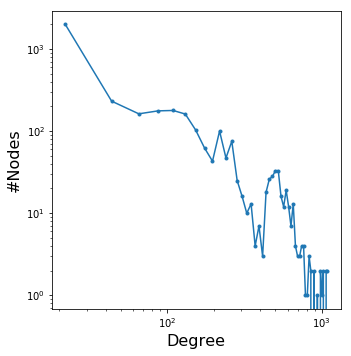

In [69]:
plt.figure(figsize = (5,5))

plt.xlabel("Degree", size = 16)
plt.ylabel("#Nodes", size = 16)
plt.tight_layout()

plt.loglog(deg_bins[1:], deg_val, marker = '.')

plt.savefig("loglog-degree-distribution.png", dpi = 400)

In [70]:
from scipy import stats

stats.linregress(np.log(deg_bins[1:][deg_val != 0]), np.log(deg_val[deg_val != 0]))

LinregressResult(slope=-1.81307980074243, intercept=13.396759439877924, rvalue=-0.9091535212901567, pvalue=2.3901547101939697e-18, stderr=0.12520677566428134)

The degree distribution also follows a power law, which is also expected.
This was verified again, by doing a linear regression.

## Plotting the network
Since there are some unconnected nodes in the network, and this makes visualization difficult, just the biggest connected component was used for this.

In [71]:
comp_G = list(nx.connected_component_subgraphs(G))

In [72]:
H = comp_G[0]
pos = nx.spring_layout(H.to_undirected(), iterations = 200)

In [73]:
import community

partition = community.best_partition(H)

In [74]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

edge_trace_x = []
edge_trace_y = []

widths = []
weights_arr = [H[edge[0]][edge[1]]['weight'] for edge in H.edges()]
max_weight = max(weights_arr)

for edge in H.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace_x += tuple([x0, x1, None])
    edge_trace_y += tuple([y0, y1, None])
    widths += tuple([np.log(1+H[edge[0]][edge[1]]['weight']/max_weight)/np.log(2)])
    
print("edge_traces loop done")

#use go.Scattergl for full network
edge_trace = go.Scatter(
    x = edge_trace_x,
    y = edge_trace_y,
    line = dict(
        width = 0.1, #widths,
        color='#000000'),
    hoverinfo='none',
    mode='lines')
print("edge_trace finished")



    
print("edges finished")

#use go.Scattergl for full network
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Jet',
        reversescale=True,
        color = [],
        size = [],
        colorbar=dict(
            thickness=5,
            title='Languages',
            xanchor='left',
            titleside='right'
        ),
        #line=dict(width=2)
    ))

print("node_trace finished")

for node in H.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

edge_traces loop done
edge_trace finished
edges finished
node_trace finished


In [75]:
langs = nx.get_node_attributes(H,'lang')
groups = set(nx.get_node_attributes(H,'lang').values())
mapping = dict(zip(sorted(groups),count()))


disp_names = nx.get_node_attributes(H, 'disp_name')
foll_counts = nx.get_node_attributes(H, 'foll_count')
urls = nx.get_node_attributes(H, 'url')

for i,node in enumerate(H.nodes()):
    node_info = 'Follow.: ' + str(foll_counts[node]) + ', Language: ' + str(langs[node])
    if foll_counts[node] > 5000:
        node_info = node_info + ', Name: ' + str(disp_names[node]) 
    elif urls[node] == urls[node]:
        node_info = node_info + ', Follow.:' + str(foll_counts[node])
        
    node_trace['text'] += tuple([node_info])
    node_trace['marker']['size'] += tuple([max([3,np.log(1+foll_counts[node]/max(foll_counts.values()))/np.log(2)*70])])
    node_trace['marker']['color'] += tuple([partition[node]])
    #node_trace['marker']['color'] += tuple([mapping[langs[node]]])
    #if color according to languages


In [76]:
fig = go.Figure(
    data = [edge_trace, node_trace],
    layout = go.Layout(
    title = "Network of accounts with more than 1000 followers, Colors based on Communities, Node size based on the number of log(Followers)",
    titlefont = dict(size=16),
    hovermode = 'closest', 
    margin = dict(b = 20, l = 5, t = 40),
    ) )

plot(fig, filename = "graph_communities.html")

'file:///mnt/c/Users/hurt0jan/Documents/projects/twitter/graph_communities.html'

Plots can be found here:
- Whole network (uses WebGL, might take some time to load, an might look quiet ugly tbh):
    - languages: https://carlomarxdk.github.io/twitter/plots/languages_full_network.html
    - communities: https://carlomarxdk.github.io/twitter/plots/communities_full_network.html
- subnetwork (just account > 1000 followers):
    - languages: https://carlomarxdk.github.io/twitter/plots/languages_foll_1000.html
    - communities: https://carlomarxdk.github.io/twitter/plots/communities_foll_1000.html

The spring layout was chosen, since, even though we varied the parameters of the ForceAtlas2 quiet a bit, the spring_layout was the nicer layout in the end.

The full (interactive-ish) plots of the network can be found on our website.

Certain clusters are very apparent, and most of them seem to correspond to the language of the accounts. (this will be further discussed in the next sections)
Especially the german and the spanish account seem to be very disconnected from the rest of the network and form their own subcommunities.

Those subclusters are very connected, we could not extract any further structure from them.



# Exploring the structure of the network even further:

#### Comparison between communities according to languages and according to the best partition
Firstly, we calculate the modularity according to the languages.

In [78]:
groups = set(nx.get_node_attributes(G,'lang').values())
mapping = dict(zip(sorted(groups),count()))
langpart = dict([(n,mapping[l]) for n,l in nx.get_node_attributes(G,'lang').items()])
community.modularity(langpart,G)

0.08435802410031122

While the values is aboth $0$, which implies, that these are actual communities, it is not much bigger than $0$, so the languages are not a very good partition into communities.

Than the louvain-algorithm was used to calculate the best partition of the network. And its modularity value was also calculated.

In [79]:
part = community.best_partition(G)
community.modularity(part,G)

0.43002311403360405

This value is quiet a lot bigger than the one recieved from the partition according to the languages

# Create confusion matrix of languages to communities (calculated by the louvain algorithm)
This was done to further investigate, how good the languages partition the network in different communities.

In [91]:
node_langs = np.array([mapping[l] for l in nx.get_node_attributes(G,'lang').values()])
node_comm = np.array(list(part.values()))

In [85]:
A = confusion_matrix(node_langs[node_comm > 2], node_comm[node_comm > 2])

comm_members = [sum(node_comm == c) for c in set(node_comm)]

comm_members_dict = dict([(c,comm_members[i]) for i,c in enumerate(set(node_comm))])

comm_more2 = np.array([ comm_members_dict[c] > 2 for c in node_comm])

A = confusion_matrix(node_langs[comm_more2], node_comm[comm_more2])

A

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  68,   0,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0],
       [ 91, 196,   7, 184, 911,   1,   0, 175,  39,   0,   0,   0,  33,
          0,   0,   0,   0,   4],
       [  1,   0,   0,   3,   0,   0,   0,   1,   0,   0,   0,   0,   4,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   0,  15,   0,   0,   0,
         12,   0,   4,   4,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [396, 145,  89, 240,   1,   0,   0,   2,   0,   0,  11,   4,  10,
          0,   3,   0,   0,   0],
       [  0,   0,   0,   0,   3,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,

In [86]:
[(l,sum(node_langs[comm_more2] == i)) for l,i in mapping.items()]

[('ar', 4),
 ('de', 69),
 ('en', 1641),
 ('en-gb', 9),
 ('es', 36),
 ('fr', 0),
 ('id', 0),
 ('it', 0),
 ('ru', 901),
 ('uk', 0),
 ('zh-cn', 3)]

In [87]:
[max(A[i])/sum(A[i]) for i in range(len(A))]

/home/hurt0jan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in long_scalars



[1.0,
 0.9855072463768116,
 0.5551492992078001,
 0.4444444444444444,
 0.4166666666666667,
 nan,
 0.43951165371809103,
 1.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

To get a sense of how good the languages correspond to the communities calculated through the louvain-algorithm, the confusion matrix was calculated (communities with less than 2 members were disregarded).
For the 3 big language-communities, the following results were found

  <b>'de':</b> $98\%$ were in the same community.
  This further verifies that the community of german-troll accounts is very clustered and fairly disconnected from the rest of the troll-network.
</p>

<p>
  <b>'en':</b> $55\%$ are in the same/biggest community.
  However, the rest is not spaced out evenly, but there is a seccond subcommunity forming with, and together they correspond to $66\%$ of the nodes with language 'en'.
</p>

<p>
  <b>'es':</b> $44\%$ are member of the biggest community.
  However, there is a second, equally big community, which also has mostly just 'es' members, together they correspond to $75\%$ of the 'es'-nodes.
</p>

<p>
  <b>'ru':</b> $43\%$ are member of the biggest community.
  However, this community is overlapping quiet a lot with a 'en'-community ($396$ nodes are 'ru' and $91$ are 'en'.)
  3 of the 4 other big 'ru' communites are also overlapping quiet a bit with 'en' communities, however, there is one community with $89$ members, that has only $7$ 'en' members.

## $C(k)$- plot
Another way to visualize the underlying structure of the network is by plotting the local klustering coefficient $C$ in dependency of the degree $k$ of each node.
This is than compared to the same plof of a random network with the same degree distribution.

In [88]:
expG = nx.expected_degree_graph(degrees)

In [89]:
cl = nx.clustering(G)
cl_coefs = np.array(list(cl.values()))

expCl = nx.clustering(expG)
expCl_coefs = np.array(list(expCl.values()))

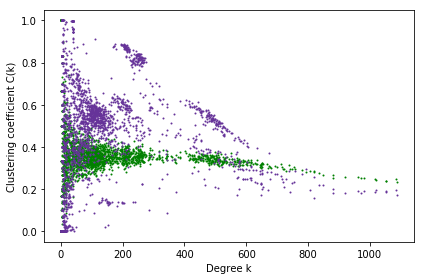

In [90]:
plt.plot(degrees, expCl_coefs, '.', color = 'green', ms = 2)
plt.plot(degrees, cl_coefs, '.', ms = 2, color = 'rebeccapurple')

plt.xlabel("Degree k")
plt.ylabel("Clustering coefficient C(k)")

plt.tight_layout()

plt.savefig("cl-k.png", dpi = 400)